In [ ]:
import cv2
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:


# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 500

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, nz, 4, 1, 0), # Output size will be (nz, 1, 1)
            nn.Tanh() # To constrain the output to a specific range
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [ ]:
# Create the generator
encoder = Encoder().to(device)
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.load_state_dict(torch.load('generator_masked_a_150_b_40.pth'))
encoder.load_state_dict(torch.load('encoder_masked_a_150_b_40.pth'))

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.load_state_dict(torch.load('discriminator_masked_a_100_b_60.pth'))

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:


def detect_and_crop_faces(image_path):
    # Load the pre-trained Haar Cascade face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Load the image
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No faces detected in the image.")
        return None

    print(f"Detected {len(faces)} faces.")

    # Crop and return each detected face
    cropped_faces = []
    for (x, y, w, h) in faces:
        # Crop the detected face
        face = image[y:y+h, x:x+w]
        cropped_faces.append(face)

    return cropped_faces




In [ ]:

# Path to the image file
image_path = 'download.jpeg'
# Call the function to detect and display faces
faces = detect_and_crop_faces(image_path)


Detected 1 faces.


In [ ]:
def display_image(image):
    # Load the image
    # image = cv2.imread(image_path)

    # # Convert BGR to RGB (Matplotlib expects RGB)
    # image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

In [ ]:
cv2.imshow("image",faces[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
import mediapipe as mp
mp_face_mesh = mp.solutions.face_mesh  

In [ ]:

import mediapipe as mp
import numpy as np
from PIL import Image





def extract_face_region(image):
    # Initialize MediaPipe face mesh
    mp_face_mesh = mp.solutions.face_mesh

    # Convert the image to RGB (MediaPipe requires RGB format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detect facial landmarks in the image
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5) as face_mesh:
        results = face_mesh.process(image_rgb)

        # Check if landmarks are detected
        if results.multi_face_landmarks:
            for detection in results.multi_face_landmarks:
                # Extract face mesh points
                face_mesh_points = []
                for landmark in detection.landmark:
                    # Convert normalized coordinates to pixel coordinates
                    height, width, _ = image.shape
                    x, y = int(landmark.x * width), int(landmark.y * height)
                    face_mesh_points.append((x, y))

                # Find convex hull of the face mesh points
                hull = cv2.convexHull(np.array(face_mesh_points), returnPoints=True)

                # Crop the facial region using the convex hull
                mask = np.zeros_like(image)
                cv2.fillPoly(mask, [hull], (255, 255, 255))
                face_region = cv2.bitwise_and(image, mask)

                # Find the bounding box of the facial region
                x, y, w, h = cv2.boundingRect(hull)
                cropped_face = face_region[y:y+h, x:x+w]

                return cropped_face

    # If no landmarks are detected, return None
    return None




In [ ]:

def get_fake(face):
    shape = face.shape[:2]
    input_image = Image.fromarray(np.uint8(faces[0])).convert("RGB")
    preprocess = transforms.Compose([
        transforms.Resize(image_size),  # Resize the image to match the input size of netG
        transforms.ToTensor(),         # Convert to tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize
    ])
    input_tensor = preprocess(input_image).unsqueeze(0).to(device)  # Add batch dimension

    # Pass the input tensor through netG to obtain the generated output
    with torch.no_grad():
        fixed_noise = encoder(input_tensor)
        fake = netG(fixed_noise).detach().cpu()

    # Visualize the generated output image
    generated_output_image = vutils.make_grid(fake, padding=2, normalize=True)
    generated_output_image = generated_output_image.permute(1, 2, 0).numpy()  # Channels last
    generated_output_image = (generated_output_image * 255).astype(np.uint8)  # Convert to uint8
    generated_output_image = cv2.cvtColor(generated_output_image, cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV
    generated_output_image = cv2.resize(generated_output_image, (shape[1], shape[0]))  # Resize to original shape
 
    return generated_output_image







In [ ]:


def detect_and_get_fake(image_path):
    # Load the pre-trained Haar Cascade face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Load the image
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No faces detected in the image.")
        return None

    print(f"Detected {len(faces)} faces.")

    # Crop and return each detected face
    cropped_faces = []
    for (x, y, w, h) in faces:
        # Crop the detected face
        face = image[y:y+h, x:x+w]
        deep_face = get_fake(face)
        deep_face = cv2.cvtColor(deep_face,cv2.COLOR_BGR2RGB)
        image[y:y+h, x:x+w] = deep_face
        
    cv2.imshow("deep_fake",image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return deep_face

    




In [ ]:
image_path = "download.jpeg"


In [ ]:
face = detect_and_get_fake(image_path)

Detected 1 faces.


In [ ]:
test_image = cv2.imread("download1.jpg")
extracted_face = extract_face_region(test_image)


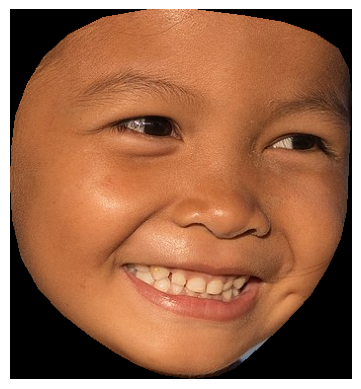

In [ ]:
image_1 = cv2.cvtColor(extracted_face,cv2.COLOR_BGR2RGB)
display_image(image_1)

In [ ]:
flipped_image = cv2.flip(image_1, 1)
fake_face = get_fake(flipped_image)

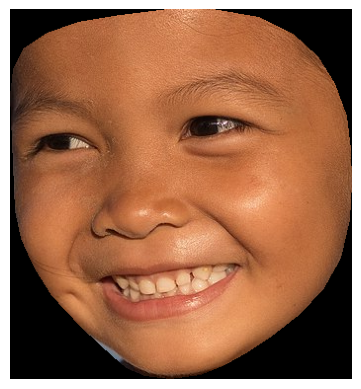

In [ ]:
display_image(flipped_image)

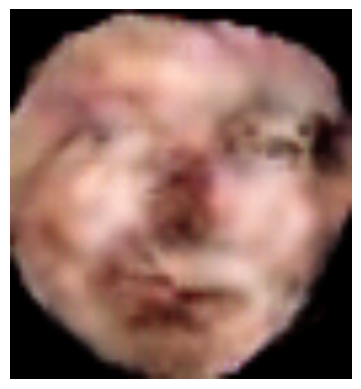

In [ ]:
display_image(cv2.cvtColor(fake_face,cv2.COLOR_BGR2RGB))

In [ ]:
# cv2.imshow("face",extracted_face)
# cv2.imshow(0)
# cv2.destroyAllWindows()
cv2.imshow("sd",extracted_face)
cv2.waitKey(0)
cv2.destroyAllWindows()